In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

## Ecuacion Diferencial Lineal de Primer Orden:
$$ y'(x)+y(x)=0 \hspace{1cm} 0 < x < 4 $$ 

### Condiciones Iniciales:
$$ y(0)=1 $$

### Solución Analítica:
$$ y(x) = e^{x} $$


In [11]:
class ODE_1st(tf.keras.Model):
    def train_step(self, data):
        # Training points and the analytical (exact) solution at this points
        x, y_exact = data
        # Initial conditions for the PINN
        x0=tf.constant([0.0], dtype=tf.float32)
        y0_exact=tf.constant([1.0], dtype=tf.float32)
        # Calculate the gradients and update weights and bias
        with tf.GradientTape() as tape:
            # Calculate the gradients dy/dx
            with tf.GradientTape() as tape2:
              tape2.watch(x0)
              tape2.watch(x)
              y0_NN = self(x0, training=True)
              y_NN  = self(x, training=True)
            dy_dx_NN= tape2.gradient(y_NN,x)
            #Loss= ODE+ boundary/initial conditions
            loss=self.compiled_loss(dy_dx_NN,-y_NN)\
                +self.compiled_loss(y0_NN,y0_exact)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y_exact, y_NN)
        return {m.name: m.result() for m in self.metrics}

In [12]:
n_train = 20
xmin = 0
xmax = 4

# Definition of the function domain
x_train=np.linspace(xmin,xmax,n_train)

# The real solution y(x) for training evaluation
y_train=tf.exp(-x_train)

# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 1

# Hiperparameters
epochs = 40

# Definition of the the model
activation='elu'
input=Input(shape=(input_neurons,))
x=Dense(50, activation=activation)(input)
x=Dense(50, activation=activation)(x)
x=Dense(50, activation=activation)(x)
output = Dense(output_neurons,activation=None)(x)
model=ODE_1st(input,output)

# Definition of the metrics, optimizer and loss
loss= tf.keras.losses.MeanSquaredError()
metrics=tf.keras.metrics.MeanSquaredError()
optimizer= Adam(learning_rate=0.001)

model.compile(loss=loss,
          optimizer=optimizer,
          metrics=[metrics])
model.summary()

history=model.fit(x_train, y_train,batch_size=1,epochs=epochs)

Model: "ode_1st_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - mean_squared_error: 0.3418 - loss: -0.1419 
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0493 - loss: 0.1077 
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0101 - loss: 0.2378 
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0104 - loss: 0.2190  
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0056 - loss: 0.2733     
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0038 - loss: 0.2324 
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 6.8636e-04 - loss: 0.3620 
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - mean_squared_error: 0.0012 - loss: 0.3076   
Epoch 9/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 0.0010 - loss: 0.1467     
Epoch 10/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - mean_squared_error: 2.5442e-04 - loss: 0.2344 
Epoch 11/40
20/20 ━━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


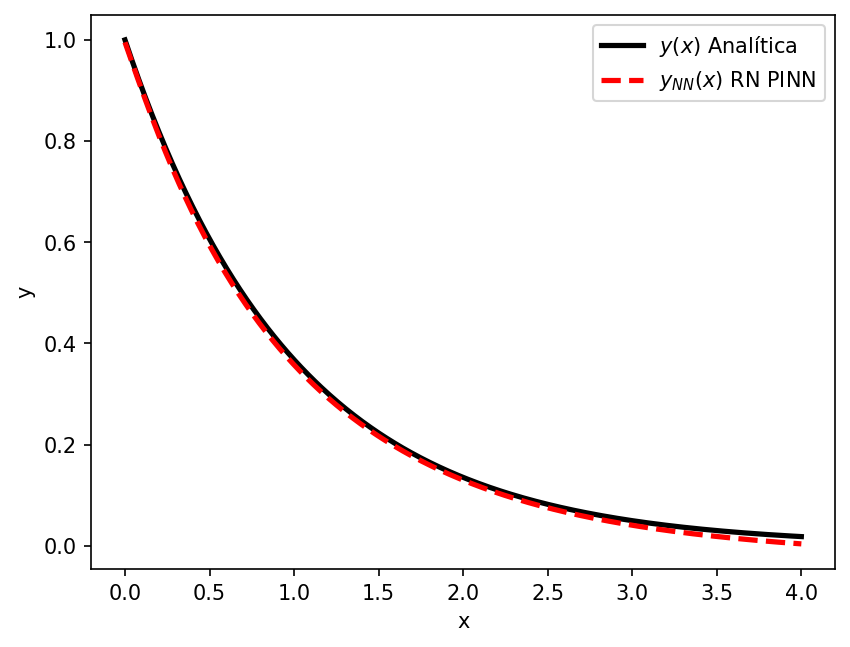

In [13]:
#Gráfico final: Se grafican las soluciones exactas, las predicciones de la red, y sus derivadas 
# (primera y segunda) para visualizar la precisión del modelo.

# Check the PINN at different points not included in the training set
n = 500
x=np.linspace(0,4,n)
y_exact=tf.exp(-x)
y_NN=model.predict(x)

# Plot the results
plt.rcParams['figure.dpi'] = 150
plt.plot(x, y_exact, color="black",linestyle='solid',
                     linewidth=2.5,label="$y(x)$ Analítica")
plt.plot(x, y_NN, color="red",linestyle='dashed',
                     linewidth=2.5, label="$y_{NN}(x)$ RN PINN")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()